# Sample DEMs at ATL06SR Point Locations

#### Steps:
* Sample various rasters at various resolutions (3m, 20m, 100m) at each ATL06SR point: snow-off DTM and slope maps

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import pickle
import pyproj

# Import file containing sampling function written by Friedrich Knuth
import core

In [3]:
%matplotlib inline

In [5]:
pd.set_option('display.max_columns', None)

### Load SlideRule data and site outline:

In [17]:
atl06sr = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10172022_processed_wo-dems_7912.pkl', 'rb'))
outline_gdf = pickle.load(open('../../data/site_outlines/methow_outline_4326.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_68182/206260649.py:2: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  outline_gdf = pickle.load(open('../../data/site_outlines/methow_outline_4326.pkl', 'rb'))


In [27]:
atl06sr.crs

<Geographic 3D CRS: EPSG:7912>
Name: ITRF2014
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: International Terrestrial Reference Frame 2014
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Convert the geometry from 2d to 3d:

In [29]:
atl06sr_7912 = atl06sr.set_geometry(gpd.points_from_xy(atl06sr.geometry.x, atl06sr.geometry.y, atl06sr.h_mean))
atl06sr_gdf = atl06sr_7912.to_crs("EPSG:2927+5703")

# Difference with Reference DTM 

## Load Snow Off DTM & Slope DTMs
The DTM was commissioned by WaDNR, flown in summer 2018.  
I created the slope raster by:  
* downscaling the DTM (to coarser resolution):  
 "gdalwarp -tr 20 20 methow_basin_2018_dtm_combined_32610_1m.tif methow_basin_2018_dtm_combined_32610_20m.tif -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER"
*   and used gdaldem to output a slope file in the command line:  
"gdaldem slope $lidar_fn  $lidar_slope_fn -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER" 

In [75]:
lidar_fn = '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_1m.tif'

In [76]:
lidar_snowoff_src = rio.open(lidar_fn)

## Sample snow-off DEM  
Using two different methods:  
1. The sample_raster function from David Shean. This uses nearest neighbor, which isn't the best interpolation method. The below function not only samples the DTM, but then computes the difference between the data using: **ICESat-2 - DTM**  
2. Using bicubic interopolation method written by Friedrich Knuth (UW) from https://github.com/uw-cryo/raster_sampling  
  
Then compare the two methods. Spoiler alert, bicubic is better. We originally used the first method, but ended up switching to the second method for the final version.  

We also ran this code for a coarser version of the DTM (downscaled to 20m resolution) but resolution didn't make a big difference so we stuck with the original high resolution.

### 1) Nearest Neighbor

In [22]:
# This function written by David Shean, UW
# This function uses nearest neighbor, which is not ideal

def sample_raster(df, src, diff_col=None):
    #df_proj = df.to_crs(src.crs)
    coord = [(pt.x, pt.y) for pt in df.to_crs(src.crs).geometry]
    s = np.fromiter(src.sample(coord), dtype=src.dtypes[0])
    #s[s == src.nodata] = np.nan
    sm = np.ma.masked_equal(s, src.nodata)
    sample_colname = os.path.splitext(os.path.split(src.name)[-1])[0]
    df[sample_colname] = sm
    if diff_col is not None:
        out_colname = '{} {} diff'.format(diff_col, sample_colname)
        df[out_colname] = df[diff_col] - df[sample_colname]
    else:
        out_colname = sample_colname
    return out_colname

In [23]:
# Sample snow-off lidar at native resolution

atl06sr_diff_col = sample_raster(atl06sr_gdf, lidar_snowoff_src, diff_col='h_mean')
atl06sr_diff_col

'h_mean methow_basin_2018_dtm_combined_32610_1m diff'

### Sample the coarser resolution snow-off data:

In [24]:
# Sample snow-off lidar at approximate resolution of ICESat-2 points

atl06sr_diff20_col = sample_raster(atl06sr_gdf, lidar_snowoff20_src, diff_col='h_mean')
atl06sr_diff20_col

'h_mean methow_basin_2018_dtm_combined_32610_20m diff'

In [64]:
atl06sr_gdf = atl06sr_gdf.rename(columns={'methow_basin_2018_dtm_combined_32610_1m':'lidar_z',
                                          'methow_basin_2018_dtm_combined_32610_20m':'lidar_z_20m',
                                          'h_mean methow_basin_2018_dtm_combined_32610_20m diff':'difference_20m',
                                          'h_mean methow_basin_2018_dtm_combined_32610_1m diff':'difference', 
                                          # 'methow_basin_2018_dtm_combined_32610_3m_slope':'slope_3m',
                                          # 'methow_basin_2018_dtm_combined_32610_20m_slope':'slope_20m',
                                          # 'methow_basin_2018_dtm_combined_32610_100m_slope':'slope_100m'
                                         })
atl06sr_gdf.columns

Index(['pflags', 'h_mean', 'dh_fit_dy', 'spot', 'w_surface_window_final',
       'h_sigma', 'distance', 'segment_id', 'dh_fit_dx', 'rgt', 'cycle',
       'delta_time', 'gt', 'n_fit_photons', 'rms_misfit', 'geometry',
       'acqdate', 'doy', 'decyear', 'dowy', 'snow_presence', 'lidar_z',
       'difference', 'lidar_z_20m', 'difference_20m', 'slope_3m', 'slope_20m',
       'slope_100m'],
      dtype='object')

In [66]:
atl06sr_gdf['difference'].describe()

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


count    146647.000000
mean         -0.517273
std           1.205088
min         -21.648634
25%          -1.019876
50%          -0.375062
75%           0.097123
max          15.269414
Name: difference, dtype: float64

In [67]:
atl06sr_gdf['difference_20m'].describe()

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


count    146662.000000
mean         -0.545213
std           2.364963
min         -32.482130
25%          -1.626569
50%          -0.369045
75%           0.625908
max          26.855712
Name: difference_20m, dtype: float64

^ These differences include snow on data. They differ only slightly depending on the resolution of the snow off lidar data

### 2) Bicubic Interpolation

In [38]:
coord = [(pt.x, pt.y) for pt in atl06sr_gdf.to_crs(lidar_snowoff_src.crs).geometry]

In [40]:
# This function was written by Friedrich Knuth, UW and is contained in core.py
# The sampling technique can be specified, here we use bicubic

bicubic_interp = core.interpolate(lidar_fn, coord, offset=3, kind='cubic')

### Convert to meters from US feet:

In [49]:
atl06sr_gdf['bicubic_lidar_z'] = bicubic_interp * 0.3048006096

In [50]:
atl06sr_gdf['bicubic_lidar_z'].describe()

count    146555.000000
mean       1164.465688
std         466.850074
min         429.967476
25%         763.416226
50%        1080.183978
75%        1564.625700
max        2511.914966
Name: bicubic_lidar_z, dtype: float64

In [48]:
atl06sr_gdf.geometry.z.describe()

count    148886.000000
mean       1171.833201
std         471.163848
min         429.798740
25%         765.990421
50%        1086.841926
75%        1578.618713
max        2511.080553
dtype: float64

### Compare snow depth calculations using the original transformation steps versus the newer, better transformation steps:  
There's a much smaller negative bias (median of -0.036 m versus -0.38 m) using the newer, better transformation steps

In [42]:
orig_atl06sr_gdf = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10172022_processed_bicubic.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_68182/1766937078.py:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  orig_atl06sr_gdf = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10172022_processed_bicubic.pkl', 'rb'))


### Calculate the difference between the ATL06-SR elevations and the bicubic-sampled snow-off lidar elevations

In [51]:
atl06sr_gdf['difference_bicubic'] = atl06sr_gdf.geometry.z - atl06sr_gdf['bicubic_lidar_z']

In [52]:
atl06sr_gdf['difference_bicubic'].describe()

count    146555.000000
mean         -0.186275
std           1.112350
min         -23.310822
25%          -0.651838
50%          -0.036163
75%           0.386887
max          14.806998
Name: difference_bicubic, dtype: float64

In [53]:
orig_atl06sr_gdf['difference_bicubic'].describe()

count    146533.000000
mean         -0.517483
std           1.198546
min         -17.800872
25%          -1.019377
50%          -0.375760
75%           0.095302
max          15.097490
Name: difference_bicubic, dtype: float64

## Bicubic Interpolation of 20m resolution slope raster:

In [77]:
slope_fn_20m = '../../data/lidar/native_res/methow_basin_2018_dtm_origcrs_combined_20m_slope.tif'
src_slo_20m = rio.open(slope_fn_20m)

In [78]:
coord = [(pt.x, pt.y) for pt in atl06sr_gdf.to_crs(src_slo_20m.crs).geometry]

In [79]:
# This function was written by Friedrich Knuth, UW and is contained in core.py
# The sampling technique can be specified, here we use bicubic

bicubic_interp = core.interpolate(slope_fn_20m, coord, offset=3, kind='cubic')

In [81]:
atl06sr_gdf['slope20'] = bicubic_interp

## Remove Dates with N < 30

In [ ]:
atl06sr_gdf['n'] = atl06sr.groupby('acqdate')['acqdate'].transform('count')
atl06sr_gdf = atl06sr_gdf[atl06sr_gdf['n'] > 30]

## Filter Outliers  
Using the difference between the ATL060SR snow-off data and the bicubic sampled snow-off DTM

In [63]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['difference_bicubic'] - atl06sr_gdf['difference_bicubic'].mean()) / atl06sr_gdf['difference_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [64]:
# get different indexes for snow on versus snow off values

atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['difference_bicubic'].abs() <=absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['difference_bicubic'].abs() <=absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

## Remove Offset Between Datasets  
ICESat-2 is measuring the ground surface as slightly below the surface of the DEM.


In [70]:
atl06sr_gdf = atl06sr_gdf.assign(diff_plus = atl06sr_gdf['difference'] - atl06sr_gdf.loc[inner_snowoff_idex, 'difference'].median())

atl06sr_gdf[atl06sr_gdf['snow_presence'] == 0]['diff_plus'].describe()

count    79932.000000
mean        -0.151839
std          1.193962
min        -21.208852
25%         -0.634525
50%          0.000000
75%          0.398409
max         15.709196
Name: diff_plus, dtype: float64

In [69]:
atl06sr_gdf = atl06sr_gdf.assign(diff_plus_bicubic = atl06sr_gdf['difference_bicubic'] - atl06sr_gdf.loc[inner_snowoff_idx,'difference_bicubic'].median()) 

atl06sr_gdf[inner_snowoff_idx]['diff_plus_bicubic'].describe()

count    78751.000000
mean        -0.136332
std          0.916780
min         -3.436143
25%         -0.561569
50%          0.000000
75%          0.334435
max          3.236326
Name: diff_plus_bicubic, dtype: float64

### Compare to the coarser resolution (20m) sampled DTM:

In [71]:
atl06sr_gdf['diff_plus_20m'] = atl06sr_gdf['difference_20m'] - atl06sr_gdf[atl06sr_gdf['snow_presence'] == 0]['difference_20m'].median()
atl06sr_gdf[atl06sr_gdf['snow_presence'] == 0]['diff_plus_20m'].describe()

count    79933.000000
mean        -0.188369
std          2.270651
min        -32.046659
25%         -1.181565
50%          0.000000
75%          0.877699
max         27.291183
Name: diff_plus_20m, dtype: float64

In [72]:
atl06sr_gdf['diff_plus'].describe()

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


count    146647.000000
mean         -0.077491
std           1.205088
min         -21.208852
25%          -0.580094
50%           0.064720
75%           0.536906
max          15.709196
Name: diff_plus, dtype: float64

In [73]:
atl06sr_gdf['diff_plus_20m'].describe()

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


count    146662.000000
mean         -0.109742
std           2.364963
min         -32.046659
25%          -1.191098
50%           0.066426
75%           1.061379
max          27.291183
Name: diff_plus_20m, dtype: float64

Text(0.5, 1.0, '20m')

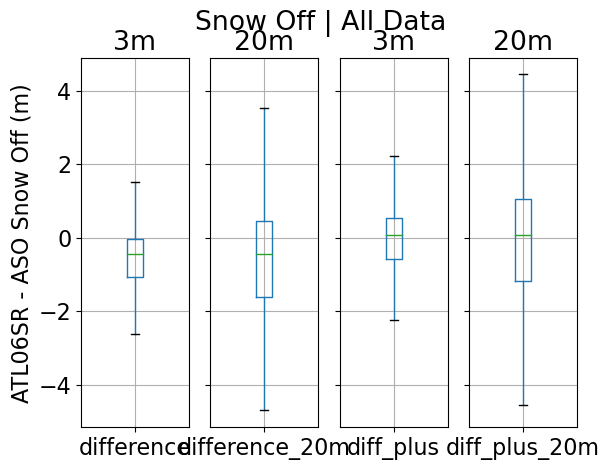

In [74]:
fig, ax = plt.subplots(1,4, sharey=True)
atl06sr_gdf[atl06sr_gdf['snow_presence'] == 0].boxplot(column=['difference'], showfliers=False, ax=ax[0])
atl06sr_gdf[atl06sr_gdf['snow_presence'] == 0].boxplot(column=['difference_20m'], showfliers=False, ax=ax[1])
atl06sr_gdf.boxplot(column=['diff_plus'], showfliers=False, ax=ax[2])
atl06sr_gdf.boxplot(column=['diff_plus_20m'], showfliers=False, ax=ax[3])
ax[0].set_ylabel('ATL06SR - ASO Snow Off (m)')
fig.suptitle('Snow Off | All Data')
ax[0].set_title('3m')
ax[1].set_title('20m')
ax[2].set_title('3m')
ax[3].set_title('20m')

The coarser resolution increases the spread. We will stick with the original resolution of 3m.

### Compare the samling techniques:

Text(0.5, 0, 'dif_plus')

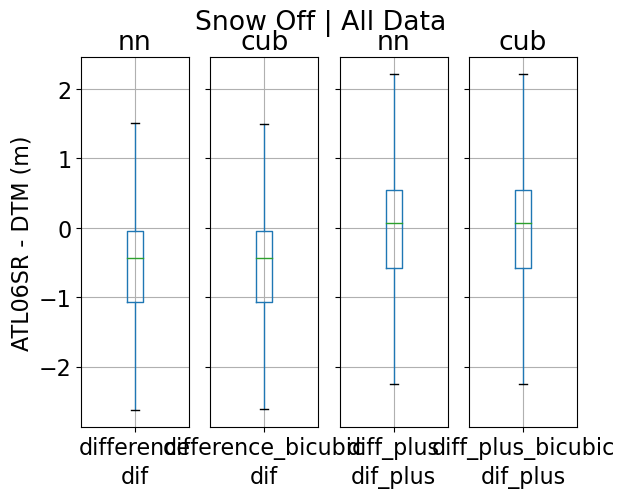

In [38]:
fig, ax = plt.subplots(1,4, sharey=True)
atl06sr_gdf[atl06sr_gdf['snow_presence'] == 0].boxplot(column=['difference'], showfliers=False, ax=ax[0])
atl06sr_gdf[atl06sr_gdf['snow_presence'] == 0].boxplot(column=['difference_bicubic'], showfliers=False, ax=ax[1])
atl06sr_gdf.boxplot(column=['diff_plus'], showfliers=False, ax=ax[2])
atl06sr_gdf.boxplot(column=['diff_plus_bicubic'], showfliers=False, ax=ax[3])
ax[0].set_ylabel('ATL06SR - DTM (m)')
fig.suptitle('Snow Off | All Data')
ax[0].set_title('nn')
ax[0].set_xlabel('dif')
ax[1].set_title('cub')
ax[1].set_xlabel('dif')
ax[2].set_title('nn')
ax[2].set_xlabel('dif_plus')
ax[3].set_title('cub')
ax[3].set_xlabel('dif_plus')

## Save these sampled fields to the original dataframe  

In [99]:
#atl06sr = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10172022_processed_wo-dems_7912.pkl', 'rb'))

In [101]:
# atl06sr['acqdate'] = atl06sr.index.date
# atl06sr['n'] = atl06sr.groupby('acqdate')['acqdate'].transform('count')
# atl06sr['h_mean_transformed'] = atl06sr_gdf.geometry.z
# atl06sr['bicubic_lidar_z'] = atl06sr_gdf['bicubic_lidar_z']
# atl06sr['difference_bicubic'] = atl06sr_gdf['difference_bicubic']
# atl06sr['zscore'] = atl06sr_gdf['zscore']
# atl06sr['diff_plus_bicubic_update'] = atl06sr_gdf['diff_plus_bicubic']
# atl06sr['slope_20m'] = atl06sr_gdf['slope20']
# atl06sr = atl06sr[atl06sr['n'] > 30]

# Save a file with all the sampled data:  

In [102]:
atl06sr_out_fn = '../../data/atl06/methow_all_sr-atl06-10172022_processed_bicubic_7912.pkl'

with open(atl06sr_out_fn, 'wb') as f:
    pickle.dump(atl06sr, f)